In [1]:
!pip install langdetect

from google.colab import files

uploaded = files.upload()

     |████████████████████████████████| 981 kB 5.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=bc14fb797bf343083ddfd529365c87e53d6b7a0b6d0692e07c1301095c52df0e
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


Saving songs_w_lyrics.json to songs_w_lyrics.json


In [2]:
import json, langdetect
import pandas as pd

with open('songs_w_lyrics.json', 'r') as f: 
    songs = json.load(f)

In [3]:
song_lens = {}
max_len = -1
y = []
X = []
songs_combined = {}

for g in songs:
    if g == 'Rock':
        songs_combined['Rock/Pop'] = songs[g]
    elif g == 'Pop':  
        songs_combined['Rock/Pop'] += songs[g]
    else:
        songs_combined[g] = songs[g]


In [4]:
import copy

songs = copy.deepcopy(songs_combined)

In [5]:
for g in songs:
    for t in songs[g]:
        lang = langdetect.detect(t[2].strip()) 
        if (lang != 'en'):
            songs[g].remove(t)
            continue

for g in songs:
    if len(songs[g]) > max_len:
        max_len = len(songs[g])
    song_lens[g] = len(songs[g])
    
for g in songs:
    c = 0
    while (len(songs[g]) != max_len):
        if (c == song_lens[g]):
            c = 0
        songs[g].append(songs[g][c])
        c += 1

songs_combined = None

for g in songs:
    print(len(songs[g]))

1731
1731
1731
1731
1731
1731
1731
1731


In [6]:
import pandas as pd

data = {'artist': [], 'song': [], 'lyrics': [], 'genre': []}

for g in songs:
    for (s, a, l) in songs[g]:
        data['artist'].append(a)
        data['song'].append(s)
        
        data['lyrics'].append(l)
        data['genre'].append(g)

df = pd.DataFrame.from_dict(data)

In [7]:
df['genre'].value_counts()


Country               1731
Rock/Pop              1731
Christian & Gospel    1731
Metal                 1731
Hip-Hop               1731
Folk & Acoustic       1731
R&B                   1731
Dance/Electronic      1731
Name: genre, dtype: int64

In [8]:
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text.replace('\n', ' ')
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df['lyrics'] = df['lyrics'].apply(clean_text)
#df['lyrics'] = df['lyrics'].str.replace('\d+', ' ')

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['lyrics'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38114 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['lyrics'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13848, 250)


In [12]:
Y = pd.get_dummies(df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13848, 8)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(12463, 250) (12463, 8)
(1385, 250) (1385, 8)


In [14]:
from keras import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding

In [15]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

In [16]:
from keras.callbacks import EarlyStopping

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
176/176 [==============================] - 138s 768ms/step - loss: 1.9262 - accuracy: 0.2482 - val_loss: 1.8195 - val_accuracy: 0.3248
Epoch 2/5
176/176 [==============================] - 136s 771ms/step - loss: 1.5483 - accuracy: 0.4361 - val_loss: 1.4043 - val_accuracy: 0.5493
Epoch 3/5
176/176 [==============================] - 135s 768ms/step - loss: 1.0473 - accuracy: 0.6530 - val_loss: 1.0829 - val_accuracy: 0.6319
Epoch 4/5
176/176 [==============================] - 136s 771ms/step - loss: 0.6732 - accuracy: 0.7890 - val_loss: 0.9415 - val_accuracy: 0.7081
Epoch 5/5
176/176 [==============================] - 136s 770ms/step - loss: 0.5854 - accuracy: 0.8307 - val_loss: 1.7267 - val_accuracy: 0.4868


In [17]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

44/44 [==============================] - 3s 78ms/step - loss: 1.6662 - accuracy: 0.5032
Test set
  Loss: 1.666
  Accuracy: 0.503


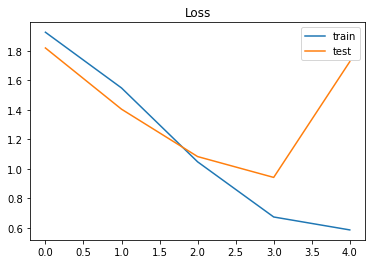

In [18]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

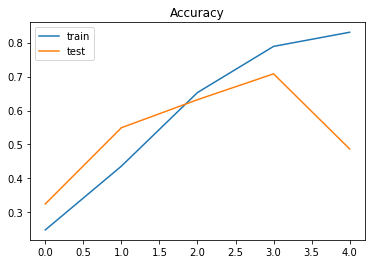

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();